In [ ]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.4 MB/s eta 0:00:00


In [ ]:
!pip install datasets transformers[sentencepiece]
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.6 MB/s eta 0:00:00


In [ ]:
import os
import re
import pickle
import string
import unicodedata
from random import randint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed

In [ ]:
!pip install -q contractions==0.0.48

In [ ]:
from contractions import contractions_dict

for key, value in list(contractions_dict.items())[:10]:
    print(f'{key} == {value}')

I'm == I am
I'm'a == I am about to
I'm'o == I am going to
I've == I have
I'll == I will
I'll've == I will have
I'd == I would
I'd've == I would have
Whatcha == What are you
amn't == am not


In [ ]:
# Using TPU

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

ValueError: ignored

In [ ]:
filename1 = 'news_summary.csv'
filename2 = 'news_summary_more.csv'

df1 = pd.read_csv(filename1, encoding='iso-8859-1').reset_index(drop=True)
df2 = pd.read_csv(filename2, encoding='iso-8859-1').reset_index(drop=True)

In [ ]:
df1.sample(5)

,author,date,headlines,read_more,text,ctext
2065,Vaibhav Gupta,"14 Dec 2016,Wednesday",Top Lashkar-e-Taiba commander killed by armed ...,http://indiatoday.intoday.in/story/sopore-enco...,Indian security forces on Wednesday killed top...,The 6-hour-long encounter in Jammu and Kashmir...
1272,Ankur Vyas,"08 Feb 2017,Wednesday",Panneerselvam acting at DMK's behest: Sasikala,http://indiatoday.intoday.in/story/sasikala-na...,Asserting that there was no rift within the pa...,AIADMK general secretary Sasikala Natarajan to...
3266,Sumedha Sehra,"22 May 2017,Monday",India a victim of terrorism: Donald Trump,http://indiatoday.intoday.in/story/india-a-vic...,US President Donald Trump said in his speech i...,"United States President Donald Trump, during h..."
4143,Daisy Mowke,"22 Mar 2017,Wednesday",Kangana to start Rani Laxmibai biopic on b'day...,http://indiatoday.intoday.in/story/kangana-ran...,"According to reports, actress Kangana Ranaut w...",Biopics seems to be the thing with Bollywood. ...
425,Radhika Chugh,"27 Jul 2017,Thursday",Court convicts school authorities for traumati...,http://www.hindustantimes.com/delhi-news/princ...,A Delhi court on Wednesday awarded a school pr...,"In an unprecedented verdict, a Delhi court on ..."


In [ ]:
df2.sample(5)

,headlines,text
20839,Signing nuclear deal may have been a mistake: ...,Iranian Foreign Minister Javad Zarif has said ...
4565,IIT Roorkee makes system to alert people a min...,Scientists at IIT Roorkee have claimed to deve...
32726,No delay in informing about Ghosh's resignatio...,India's largest airline IndiGo on Thursday sai...
23964,Prakash Jha to direct a biopic on a Bihar math...,Prakash Jha is set to direct a biopic on Bihar...
89971,"Pak pilot sleeps on flight, leaves control wit...",A senior Pakistan International Airlines (PIA)...


In [ ]:
df1_columns = df1.columns.tolist()
df1_columns.remove('headlines')
df1_columns.remove('text')
df1.drop(df1_columns, axis='columns', inplace=True)

df = pd.concat([df1, df2], axis='rows')
del df1, df2

# Shuffling the df
df = df.sample(frac=1).reset_index(drop=True)

print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 102915


,headlines,text
62787,Astronomers narrow down on source of mysteriou...,Astronomers have found evidence that repeated ...
5556,Flipkart's Snapdeal buyout said to benefit Tig...,Flipkart's reported $1 billion buyout of Snapd...
61322,K'taka govt prohibits protest by waste contrac...,The Karnataka government has invoked the Essen...
13159,Banks didn't implement demonetisation properly...,Bihar CM Nitish Kumar on Sunday blamed the ban...
22906,Mumbai Indians ease past Sunrisers Hyderabad,Mumbai Indians eased to a 4-wicket win over de...


In [ ]:
def expand_contractions(text, contraction_map=contractions_dict):
    # Using regex for getting all contracted words
    contractions_keys = '|'.join(contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    def expand_match(contraction):
        # Getting entire matched sub-string
        match = contraction.group(0)
        expanded_contraction = contraction_map.get(match)
        if not expand_contractions:
            print(match)
            return match
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


# Converting to lowercase
df.text = df.text.apply(str.lower)
df.headlines = df.headlines.apply(str.lower)
df.headlines = df.headlines.apply(expand_contractions)
df.text = df.text.apply(expand_contractions)
df.sample(5)


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Remove puncuation from word
def rm_punc_from_word(word):
    clean_alphabet_list = [
        alphabet for alphabet in word if alphabet not in string.punctuation
    ]
    return ''.join(clean_alphabet_list)

# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)

# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space

# Remove stopwords from text
def rm_stopwords_from_text(text):
    _stopwords = stopwords.words('english')
    text = text.split()
    word_list = [word for word in text if word not in _stopwords]
    return ' '.join(word_list)

# Cleaning text
def clean_text(text):
    text = text.lower()
    text = rm_punc_from_text(text)
    text = rm_number_from_text(text)
    text = rm_stopwords_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    # remove accented chars ('Sómě Áccěntěd těxt' => 'Some Accented text')
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode(
        'utf-8', 'ignore'
    )

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',
                  str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except Exception as e:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

df.text = df.text.apply(clean_text)
df.headlines = df.headlines.apply(clean_text)
df.sample(5)

,headlines,text
17678,making big west never sethemed worth dharmendra,veteran actor dharmendra said though actors tr...
4602,congress leaders meet ec dthemand action amit ...,congress leaders approached election commissio...
94404,woman petitioned nikah halala receives threats,delhibased woman petitioned nikah halala suprt...
90871,aaa1 lakh robot clap hands dthemand made,japanese designer masato takahashi developed r...
94616,us police offer test meth deadly gluten,california police officers offered test meth d...


In [ ]:
# saving the cleaned data
df.to_csv('preprocessed_data.csv')

In [ ]:
df.headlines = df.headlines.apply(lambda x: f'_START_ {x} _END_')
start_token = 'sostok'
end_token = 'eostok'
df.headlines = df.headlines.apply(lambda x: f'{start_token} {x} {end_token}')
df.sample(5)

,headlines,text
58717,sostok _START_ aamir khan unveils first look p...,actor aamir khan today unveiled first look pos...
98062,sostok _START_ gujarat assthembly increases ml...,mthember gujarat assthembly wednesday passed b...
94008,sostok _START_ rbi prove credibility dthemonet...,vice president venkaiah naidu monday urged res...
80217,sostok _START_ sharjahbound plane makes themer...,sharjahbound air arabia plane made themergency...
79001,sostok _START_ amu follows taliban ideology bj...,news reports claimed posters showing map india...


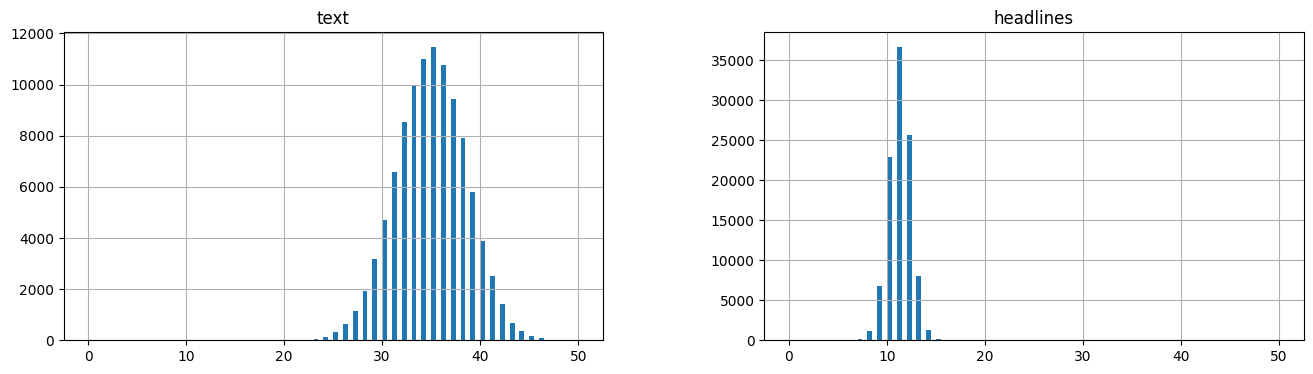

In [ ]:
text_count = [len(sentence.split()) for sentence in df.text]
headlines_count = [len(sentence.split()) for sentence in df.headlines]

pd.DataFrame({'text': text_count, 'headlines': headlines_count}).hist(bins=100, figsize=(16, 4), range=[0, 50])
plt.show()

In [ ]:
# To check how many rows in a column has length (of the text) <= limit
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)


# Check how many % of headlines have 0-13 words
print(get_word_percent(df.headlines, 14))

# Check how many % of summary have 0-42 words
print(get_word_percent(df.text, 43))

1.0
0.99


In [ ]:
max_text_len = 43
max_summary_len = 14
# select the summary and text between their defined max lens respectively
def trim_text_and_summary(df, max_text_len, max_summary_len):
    cleaned_text = np.array(df['text'])
    cleaned_summary = np.array(df['headlines'])

    short_text = []
    short_summary = []

    for i in range(len(cleaned_text)):
        if len(cleaned_text[i].split()) <= max_text_len and len(
            cleaned_summary[i].split()
        ) <= max_summary_len:
            short_text.append(cleaned_text[i])
            short_summary.append(cleaned_summary[i])

    df = pd.DataFrame({'text': short_text, 'summary': short_summary})
    return df


df = trim_text_and_summary(df, max_text_len, max_summary_len)
print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 102112


,text,summary
91380,government ded pay special protection group pe...,sostok _START_ spg officers get highest dress ...
26499,indians taken snapchat ceo evan spiegels fianc...,sostok _START_ indians troll snapchat ceofs fi...
10402,icici bank ceo chanda kochhars brotherinlaw ra...,sostok _START_ chanda kochhars brotherinlaw de...
91513,total bills listed introduction parliaments mo...,sostok _START_ bills listed introduction monso...
77961,russian social media network vkontakte allowed...,sostok _START_ russian social network lets use...


In [ ]:
# rare word analysis
def get_rare_word_percent(tokenizer, threshold):
    # threshold: if the word's occurrence is less than this then it's rare word

    count = 0
    total_count = 0
    frequency = 0
    total_frequency = 0

    for key, value in tokenizer.word_counts.items():
        total_count += 1
        total_frequency += value
        if value < threshold:
            count += 1
            frequency += value

    return {
        'percent': round((count / total_count) * 100, 2),
        'total_coverage': round(frequency / total_frequency * 100, 2),
        'count': count,
        'total_count': total_count
    }


In [ ]:
# Splitting the training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    np.array(df['text']),
    np.array(df['summary']),
    test_size=0.1,
    random_state=1,
    shuffle=True
)

In [ ]:
x_train[0]

'praising son ranbir kapoors girlfriend alia bhatt rishi kapoor said admire taking challenging roles like highway raazi isdifficult tender age carry film shoulders actor added rishi said alia lucky course talent'

In [ ]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

x_tokens_data = get_rare_word_percent(x_tokenizer, 4)
print(x_tokens_data)

{'percent': 65.26, 'total_coverage': 2.92, 'count': 65806, 'total_count': 100835}


In [ ]:
# save tokenizer
with open('x_tokenizer', 'wb') as f:
    pickle.dump(x_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# one-hot-encoding
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)

# padding upto max_text_len
x_train_padded = pad_sequences(x_train_sequence, maxlen=max_text_len, padding='post')
x_val_padded = pad_sequences(x_val_sequence, maxlen=max_text_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
x_vocab_size = len(x_tokenizer.word_index) + 1

print(x_vocab_size)

100836


In [ ]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_tokens_data = get_rare_word_percent(y_tokenizer, 6)
print(y_tokens_data)

{'percent': 69.2, 'total_coverage': 4.74, 'count': 26216, 'total_count': 37885}


In [ ]:
# save tokenizer
with open('y_tokenizer', 'wb') as f:
    pickle.dump(y_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# one-hot-encoding
y_train_sequence = y_tokenizer.texts_to_sequences(y_train)
y_val_sequence = y_tokenizer.texts_to_sequences(y_val)

# padding upto max_summary_len
y_train_padded = pad_sequences(y_train_sequence, maxlen=max_summary_len, padding='post')
y_val_padded = pad_sequences(y_val_sequence, maxlen=max_summary_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
y_vocab_size = len(y_tokenizer.word_index) + 1

# else use this
# y_vocab_size = y_tokenizer.num_words + 1

print(y_vocab_size)

37886


In [ ]:
# removing summary which only has sostok & eostok
def remove_indexes(summary_array):
    remove_indexes = []
    for i in range(len(summary_array)):
        count = 0
        for j in summary_array[i]:
            if j != 0:
                count += 1
        if count == 2:
            remove_indexes.append(i)
    return remove_indexes


remove_train_indexes = remove_indexes(y_train_padded)
remove_val_indexes = remove_indexes(y_val_padded)

y_train_padded = np.delete(y_train_padded, remove_train_indexes, axis=0)
x_train_padded = np.delete(x_train_padded, remove_train_indexes, axis=0)

y_val_padded = np.delete(y_val_padded, remove_val_indexes, axis=0)
x_val_padded = np.delete(x_val_padded, remove_val_indexes, axis=0)


In [ ]:
latent_dim = 240
embedding_dim = 300
num_epochs = 50

In [ ]:
def get_embedding_matrix(tokenizer, embedding_dim, vocab_size=None):
    word_index = tokenizer.word_index
    voc = list(word_index.keys())

    path_to_glove_file = 'glove.6B.300d.txt'

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    num_tokens = len(voc) + 2 if not vocab_size else vocab_size
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    return embedding_matrix


x_embedding_matrix = get_embedding_matrix(x_tokenizer, embedding_dim, x_vocab_size)
y_embedding_matrix = get_embedding_matrix(y_tokenizer, embedding_dim, y_vocab_size)

Found 8882 word vectors.
Converted 7880 words (92955 misses)
Found 8882 word vectors.
Converted 7194 words (30691 misses)


In [ ]:
def build_hybrid_seq2seq_model(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU

        #Encoder
        encoder_input = Input(shape=(max_text_len, ))
        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False,
            name='encoder_embedding'
        )(encoder_input)

        # encoder lstm1
        encoder_bi_lstm1 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_1'
            ),
            name='encoder_bidirectional_lstm_1'
        )
        encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_bi_lstm1(
            encoder_embedding
        )
        encoder_bi_lstm1_output = [
            encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1
        ]

        # encoder lstm 2
        encoder_bi_lstm2 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_2'
            ),
            name='encoder_bidirectional_lstm_2'
        )
        encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_bi_lstm2(
            encoder_output1
        )
        encoder_bi_lstm2_output = [
            encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2
        ]

        # encoder lstm 3
        encoder_bi_lstm = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_3'
            ),
            name='encoder_bidirectional_lstm_3'
        )
        encoder_output, *encoder_final_states = encoder_bi_lstm(encoder_output2)

        #Decoder

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=False,
            name='decoder_embedding'
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        decoder_lstm = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.2,
            name='decoder_lstm_1'
        )
        decoder_output, *decoder_final_states = decoder_lstm(
            decoder_embedding, initial_state=encoder_final_states[:2]
        )  # taking only the forward states

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        #Model
        model = Model([encoder_input, decoder_input], decoder_output, name='seq2seq_model_with_bidirectional_lstm')
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_lstm,
                    'dense': decoder_dense
                }
            }
        }

In [ ]:
seq2seq = build_hybrid_seq2seq_model(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

Model: "seq2seq_model_with_bidirectional_lstm"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 43)]                 0         []                            
                                                                                                  
 encoder_embedding (Embeddi  (None, 43, 300)              3025080   ['input_1[0][0]']             
 ng)                                                      0                                       
                                                                                                  
 encoder_bidirectional_lstm  [(None, 43, 480),            1038720   ['encoder_embedding[0][0]']   
 _1 (Bidirectional)           (None, 240),                                                        
                              (None, 240),                    

In [ ]:
model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

In [ ]:
model.layers[-2].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'decoder_embedding')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'encoder_bidirectional_lstm_3')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'encoder_bidirectional_lstm_3')>]

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000001, verbose=1),
]

In [ ]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128 ,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/50


 72/718 [==>...........................] - ETA: 1:28:09 - loss: 6.5982 - accuracy: 0.3023

KeyboardInterrupt: ignored

In [ ]:
# Next, let’s build the dictionary to convert the index to word for target and source vocabulary:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [ ]:
def build_hybrid_seq2seq_model_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_bi_lstm
):

    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_forward_input_h = Input(shape=(latent_dim, ))
    decoder_state_forward_input_c = Input(shape=(latent_dim, ))
    # decoder_state_backward_input_h = Input(shape=(latent_dim, ))
    # decoder_state_backward_input_c = Input(shape=(latent_dim, ))

    # Create the hidden input layer with twice the latent dimension,
    # since we are using bi - directional LSTM's we will get
    # two hidden states and two cell states
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim * 2))

    decoder_initial_state = [
        decoder_state_forward_input_h, decoder_state_forward_input_c,
        #decoder_state_backward_input_h, decoder_state_backward_input_c
    ]

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_bi_lstm(
        decoder_embedding, initial_state=decoder_initial_state
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input] + decoder_initial_state,
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)


In [ ]:
encoder_model, decoder_model = build_hybrid_seq2seq_model_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [ ]:
def decode_sequence_hybrid_seq2seq_model(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, *state_values = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, *decoder_states = decoder_model.predict(
            [target_seq] + [e_out] + state_values[:2]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) # Greedy Search
        sampled_token = reverse_target_word_index[sampled_token_index + 1]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        state_values = decoder_states

    return decoded_sentence

In [ ]:
def seq2summary(input_sequence):
    new_string = ''
    for i in input_sequence:
        if (
            (i != 0 and i != target_word_index[start_token]) and
            (i != target_word_index[end_token])
        ):
            new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string

In [ ]:
def seq2text(input_sequence):
    new_string = ''
    for i in input_sequence:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '
    return new_string

In [ ]:
def predict_text(text, decode_sequence, encoder_model, decoder_model):
    original_text = text
    text = clean_text([text])  # generator
    text_list = original_text.split()

    if len(text_list) <= max_text_len:
        text = expand_contractions(text)
        text = clean_text(text)
        text = f'_START_ {text} _END_'
        text = f'{start_token} {text} {end_token}'

        seq = x_tokenizer.texts_to_sequences([' '.join(text_list)])
        padded = pad_sequences(seq, maxlen=max_text_len, padding='post')
        pred_summary = decode_sequence(
            padded.reshape(1, max_text_len), encoder_model, decoder_model
        )
        return pred_summary
    else:
        pred_summary = ''

        # breaking long texts to individual max_text_len texts and predicting on them
        while len(text_list) % max_text_len == 0:
            text_list.append('')

        lst_i = max_text_len
        for i in range(0, len(text_list), max_text_len):
            _text_list = original_text.split()[i:i + lst_i]
            _text = ' '.join(_text_list)
            _text = ' '.join(
                _text.split()
            )  # to remove spaces that were added to make len(text_list) % max_text_len == 0

            _text = expand_contractions(_text)
            _text = clean_text(_text)  # generator
            _text = f'_START_ {_text} _END_'
            _text = f'{start_token} {_text} {end_token}'
            # print(_text, '\n')

            _seq = x_tokenizer.texts_to_sequences([_text])
            _padded = pad_sequences(_seq, maxlen=max_text_len, padding='post')
            _pred = decode_sequence(
                _padded.reshape(1, max_text_len), encoder_model, decoder_model
            )
            pred_summary += ' ' + ' '.join(_pred.split()[1:-2])
            pred_summary = ' '.join(pred_summary.split())

        return pred_summary

In [ ]:
# Testing on training data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_hybrid_seq2seq_model(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

In [ ]:
# Testing on validation data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(x_val_padded[i]))
    print("Original summary: ", seq2summary(y_val_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_just_lstm(
            x_val_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

In [ ]:
# HDF5 format
model.save('model.h5')
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

In [ ]:
x_train=x_train.tolist()
y_train=y_train.tolist()
x_train[:1000]

['praising son ranbir kapoors girlfriend alia bhatt rishi kapoor said admire taking challenging roles like highway raazi isdifficult tender age carry film shoulders actor added rishi said alia lucky course talent',
 'indianorigin mohammed dewji africas youngest billionaire aged returned home safely kidnapped unidentified men way gym tanzania days ago kidnappers abandoned dewji found police dewji hands legs face tied throughout captivity could identify abductors',
 'richa chadha aditi rao hydari rahul bhat starrer daas dev released today messy cocktail themotions power games wrote hindustan times ht totality film grip said times india toi indian express wrote film enough impact rated ht toi indian express',
 'tenth edition indian prthemier league saw records broken mumbai indians became first team win three ipl titles going past kolkata knight riders chennai super kings two titles gujarat lions recorded worst ipl collapse lastever match royal challengers bangalore posted lowestever ipl 

In [ ]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, Trainer, TrainingArguments
import torch


class PegasusDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels['input_ids'][idx])  # torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels['input_ids'])  # len(self.labels)


def prepare_data(model_name,
                 train_texts, train_labels,
                 val_texts=None, val_labels=None,
                 test_texts=None, test_labels=None):
  """
  Prepare input data for model fine-tuning
  """
  tokenizer = PegasusTokenizer.from_pretrained(model_name)

  prepare_val = False if val_texts is None or val_labels is None else True
  prepare_test = False if test_texts is None or test_labels is None else True

  def tokenize_data(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True)
    decodings = tokenizer(labels, truncation=True, padding=True)
    dataset_tokenized = PegasusDataset(encodings, decodings)
    return dataset_tokenized

  train_dataset = tokenize_data(train_texts, train_labels)
  val_dataset = tokenize_data(val_texts, val_labels) if prepare_val else None
  test_dataset = tokenize_data(test_texts, test_labels) if prepare_test else None

  return train_dataset, val_dataset, test_dataset, tokenizer


def prepare_fine_tuning(model_name, tokenizer, train_dataset, val_dataset=None, freeze_encoder=False, output_dir='./results'):
  """
  Prepare configurations and base model for fine-tuning
  """
  torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)

  if freeze_encoder:
    for param in model.model.encoder.parameters():
      param.requires_grad = False

  if val_dataset is not None:
    training_args = TrainingArguments(
      output_dir=output_dir,           # output directory
      num_train_epochs=2000,           # total number of training epochs
      per_device_train_batch_size=1,   # batch size per device during training, can increase if memory allows
      per_device_eval_batch_size=1,    # batch size for evaluation, can increase if memory allows
      save_steps=500,                  # number of updates steps before checkpoint saves
      save_total_limit=5,              # limit the total amount of checkpoints and deletes the older checkpoints
      evaluation_strategy='steps',     # evaluation strategy to adopt during training
      eval_steps=100,                  # number of update steps before evaluation
      warmup_steps=500,                # number of warmup steps for learning rate scheduler
      weight_decay=0.01,               # strength of weight decay
      logging_dir='./logs',            # directory for storing logs
      logging_steps=10,
    )

    trainer = Trainer(
      model=model,                         # the instantiated 🤗 Transformers model to be trained
      args=training_args,                  # training arguments, defined above
      train_dataset=train_dataset,         # training dataset
      eval_dataset=val_dataset,            # evaluation dataset
      tokenizer=tokenizer
    )

  else:
    training_args = TrainingArguments(
      output_dir=output_dir,           # output directory
      num_train_epochs=2000,           # total number of training epochs
      per_device_train_batch_size=1,   # batch size per device during training, can increase if memory allows
      save_steps=500,                  # number of updates steps before checkpoint saves
      save_total_limit=5,              # limit the total amount of checkpoints and deletes the older checkpoints
      warmup_steps=500,                # number of warmup steps for learning rate scheduler
      weight_decay=0.01,               # strength of weight decay
      logging_dir='./logs',            # directory for storing logs
      logging_steps=10,
    )

    trainer = Trainer(
      model=model,                         # the instantiated 🤗 Transformers model to be trained
      args=training_args,                  # training arguments, defined above
      train_dataset=train_dataset,         # training dataset
      tokenizer=tokenizer
    )

  return trainer


if __name__=='__main__':
  # use XSum dataset as example, with first 1000 docs as training data
  #from datasets import load_dataset
  #dataset = load_dataset("xsum")
  train_texts, train_labels = x_train[:1000], y_train[:1000]

  # use Pegasus Large model as base for fine-tuning
  model_name = 'google/pegasus-large'
  train_dataset, _, _, tokenizer = prepare_data(model_name, train_texts, train_labels)
  trainer = prepare_fine_tuning(model_name, tokenizer, train_dataset)
  trainer.train()

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,8.625200
20,8.503600
30,8.374200
40,7.645700
50,7.522800
60,7.306500
70,7.648700
80,7.570100
90,7.002800
100,7.422100


In [ ]:
trainer.evaluate()